In [1]:
import pandas as pd
import numpy as np
import random as rnd
from termcolor import colored

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

bold_start = '\033[1m'
underline_start = '\033[4m'
bu_end = '\033[0m'


Reading the data and understading the types

In [2]:
train_df = pd.read_csv('death_prediction_synthetic.csv')

In [3]:
des_df = {  'attName':[],
            'count':[],
            'mean':[],
            'std':[], 
            'min':[], 
            '25%':[], 
            '50%':[], 
            '75%':[], 
            'max':[]
            }
for att in train_df.columns:
    description = train_df[att].describe(include='all')
    des_df['attName'].append(att)
    for key in list(des_df.keys())[1:]:
        try:
            des_df[key].append(description[key])
        except:
            des_df[key].append(np.NaN)
des_df = pd.DataFrame(data=des_df)
des_df.to_csv("description.csv")
des_df.head()

,attName,count,mean,std,min,25%,50%,75%,max
0,age,12438.0,43.501126,4.802035,30.0,41.0,45.0,48.0,49.0
1,sex,12438.0,1.468805,0.499046,1.0,1.0,1.0,2.0,2.0
2,marital_status,12438.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ses,12438.0,1.677279,0.763641,1.0,1.0,1.0,2.0,3.0
4,residence_cd,12438.0,1.062631,0.242307,1.0,1.0,1.0,1.0,2.0


In [4]:
numberOfPeople = train_df.shape[0]
totalDeath = train_df["dead_5y"].sum()

The following will justify why we choose our approach. In summary, according to the Central Bureau of Statistics the data we are dealing with have a large rate of sick (causes of death) people. 

We decided to use unsupervised learning to classify the risk groups. Unsupervised learning allows us to automatically identify patterns in the data and classify them into risk groups. This is a more efficient way of dealing with data that has a large rate of sick people, as it requires less manual intervention and will provide more accurate results.

In [5]:
old_death_population = {
    2018: (1770, 2229702),
    2017: (1780, 2191646),
    2016: (1798, 2150096),
    2015: (1697, 2110721),
    2014: (1733, 2070562),
    2013: (1694, 2030785),
    2012: (1699, 1990188),
    2011: (1704, 1952624),
    }
print(f'{"Year":<8s} | {"Death":<10s} | {"Population":<10s} | {"DeathRate":<10s}')
for year in old_death_population.keys():
    death_rate_s = round((old_death_population[year][0]/old_death_population[year][1])*100, 4)
    print(f'{year:<8} | {old_death_population[year][0]:<10} | {old_death_population[year][1]:<10} | {death_rate_s:<10}%')

print(bold_start + underline_start+  f'{"Data":<8} | {totalDeath:<10} | {numberOfPeople:<10} | {str(round(totalDeath/numberOfPeople*100, 4)):<10}%' + bu_end)


Year     | Death      | Population | DeathRate 
2018     | 1770       | 2229702    | 0.0794    %
2017     | 1780       | 2191646    | 0.0812    %
2016     | 1798       | 2150096    | 0.0836    %
2015     | 1697       | 2110721    | 0.0804    %
2014     | 1733       | 2070562    | 0.0837    %
2013     | 1694       | 2030785    | 0.0834    %
2012     | 1699       | 1990188    | 0.0854    %
2011     | 1704       | 1952624    | 0.0873    %
Data     | 197        | 12438      | 1.5839    %


The following section will be the data preparation, we'll preform data cleaning, transformation, selection etc. It's like putting together a puzzle; gathering the pieces, arranging them in the right order and ensuring no pieces are missing.

First we'll find the attributes contains NULL values.

In [6]:
nullContainAtt = dict()
print(f'{"Attribute":<14} {"Null Values":} ')
for attName in train_df.columns:
    train_df[train_df == "NA"] = np.nan
    train_df[train_df == "NaN"] = np.nan
    numOfNulls = train_df[attName].isna().sum()
    if numOfNulls > 0:
        nullContainAtt[attName] = [numOfNulls, numOfNulls/numberOfPeople]
        print(f'{bold_start}{attName:<14} {numOfNulls:>6}{bu_end}')
train_df[train_df == "NA"] = np.nan
train_df[train_df == "NaN"] = np.nan

Attribute      Null Values 
albumin          1463
alb24h           8918
ACR              1212
gravity_u        2530
nitrites_u       2520
leuko_u          2507
proteinuria      2506


The description file helps to understand that cancer have no effect so we'll remove this attribute

In [7]:
train_df = train_df.drop(["cancer"], axis=1)
train_df.head()

,age,sex,marital_status,ses,residence_cd,residence,weigh,heigh,BMI,bp_sys,...,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
0,49,2,U,1,1,urban,84.0,160.0,32.79,116,...,1,0.12908,1,0,0,1,1,1,0,0
1,46,2,M,1,1,urban,67.0,152.0,29.38,113,...,1,0.08500,1,0,0,0,1,1,0,0
2,46,2,U,1,1,urban,62.4,148.0,28.31,133,...,1,0.10715,1,0,0,1,1,1,0,0
3,45,1,U,2,1,urban,73.9,166.0,26.85,100,...,1,0.10110,1,0,0,0,0,1,0,0
4,49,2,U,1,1,urban,53.0,161.0,20.45,110,...,1,0.03950,1,0,0,0,0,1,0,0


In [8]:
train_df.select_dtypes(exclude=['int64', 'float64'])

,marital_status,residence,bp_cat,smoking_status
0,U,urban,Normal,non_smoker
1,M,urban,Normal,non_smoker
2,U,urban,Pre-HTN,non_smoker
3,U,urban,Normal,current_smoker
4,U,urban,Normal,non_smoker
...,...,...,...,...
12433,U,urban,Pre-HTN,non_smoker
12434,M,urban,Normal,non_smoker
12435,U,urban,Normal,current_smoker
12436,M,urban,Normal,non_smoker


In [9]:
train_df['residence'].value_counts(), train_df['residence_cd'].value_counts()

(urban    11659
 rural      779
 Name: residence, dtype: int64,
 1    11659
 2      779
 Name: residence_cd, dtype: int64)

We can drop the string residence column since the residence and residence_cd columns both contain the same values.

In [10]:
train_df = train_df.drop(["residence"], axis=1)

נשנה את סטטוס הנישואים למספרי בהתאם למה שעשינו לפני

In [11]:
train_df['marital_status'] = train_df['marital_status'].map({"U" : 1, "M": 2})

In [12]:
train_df.select_dtypes(exclude=['int64', 'float64'])

,bp_cat,smoking_status
0,Normal,non_smoker
1,Normal,non_smoker
2,Pre-HTN,non_smoker
3,Normal,current_smoker
4,Normal,non_smoker
...,...,...
12433,Pre-HTN,non_smoker
12434,Normal,non_smoker
12435,Normal,current_smoker
12436,Normal,non_smoker


נבדוק קורלציה בין ביפי_קאט לעמודות השונות

In [13]:
train_df['bp_cat'] = train_df['bp_cat'].map({"Normal": 0, "Pre-HTN": 1, "HTN-G1": 2, "HTN-G2": 3, "HTN-G3": 4}).astype(int)

In [14]:
train_df.loc[(train_df['bp_cat'] == 1)]

,age,sex,marital_status,ses,residence_cd,weigh,heigh,BMI,bp_sys,bp_dias,...,Charlson,framingham_cvd,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y
2,46,2,1,1,1,62.40,148.0,28.31,133,87,...,1,0.10715,1,0,0,1,1,1,0,0
9,44,2,2,1,1,72.00,164.0,26.77,137,76,...,2,0.09586,1,0,0,0,0,0,0,0
10,33,1,2,1,1,112.00,185.0,32.72,130,80,...,1,0.03946,1,0,0,1,1,1,0,0
17,49,2,2,2,1,78.00,157.5,31.24,130,89,...,1,0.11276,1,0,0,1,1,1,1,0
19,45,1,1,2,1,83.00,169.0,29.06,117,86,...,1,0.08349,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12417,49,1,2,1,1,78.00,175.0,25.60,137,86,...,3,0.37036,1,0,0,1,1,1,1,0
12425,44,2,2,2,1,98.85,167.0,35.14,130,80,...,1,0.11030,1,0,0,0,0,1,0,0
12429,48,2,1,2,1,80.00,161.0,30.86,130,75,...,3,0.16726,1,0,0,0,0,1,1,0
12432,48,1,2,1,2,94.00,170.0,32.53,126,85,...,1,0.41173,1,0,0,1,1,1,0,0


In [15]:
max(train_df['bp_sys']), max(train_df['bp_dias'])

(200, 135)

The first table shows the countnious features correlation, we'll deal the categorical features later.

In [16]:
def plot_correlation(method='pearson'):
    cor = train_df.corr(method=method)
    plt.figure(figsize=(25,25))
    sns.heatmap(np.abs(round(cor, 3)), annot=True, cmap='Greys')
    plt.show() 

In [17]:
plot_correlation()

#In the following part we'll deal with feature selection in order to avoid multicollinearity 

High correlation between bp_sys and bp_dias to bp cat so we think that bp_cat maps those two features well

In [ ]:
train_df.to_csv('new_dataset.csv')

In [ ]:
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(1,2,1, projection='3d')
# ax1 = fig.add_subplot(1,2,2)
# ax.scatter(train_df['bp_sys'], train_df['bp_dias'], train_df['bp_cat'], marker='.')
# ax1.scatter(train_df['bp_sys'], train_df['bp_dias'], marker='.')
# ax.view_init(15,85), ax1
from sklearn.decomposition import PCA
bp_pca = train_df[['bp_sys', 'bp_dias', 'bp_cat']]
pca = PCA(n_components=2)
pca.fit(bp_pca)
data_pca = pca.transform(bp_pca)
train_df['PC1'] = data_pca[:, 0]
train_df['PC2'] = data_pca[:, 1]

C:\Users\talro\AppData\Local\Temp\ipykernel_31992\1575577011.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train_df.corr(method=method)


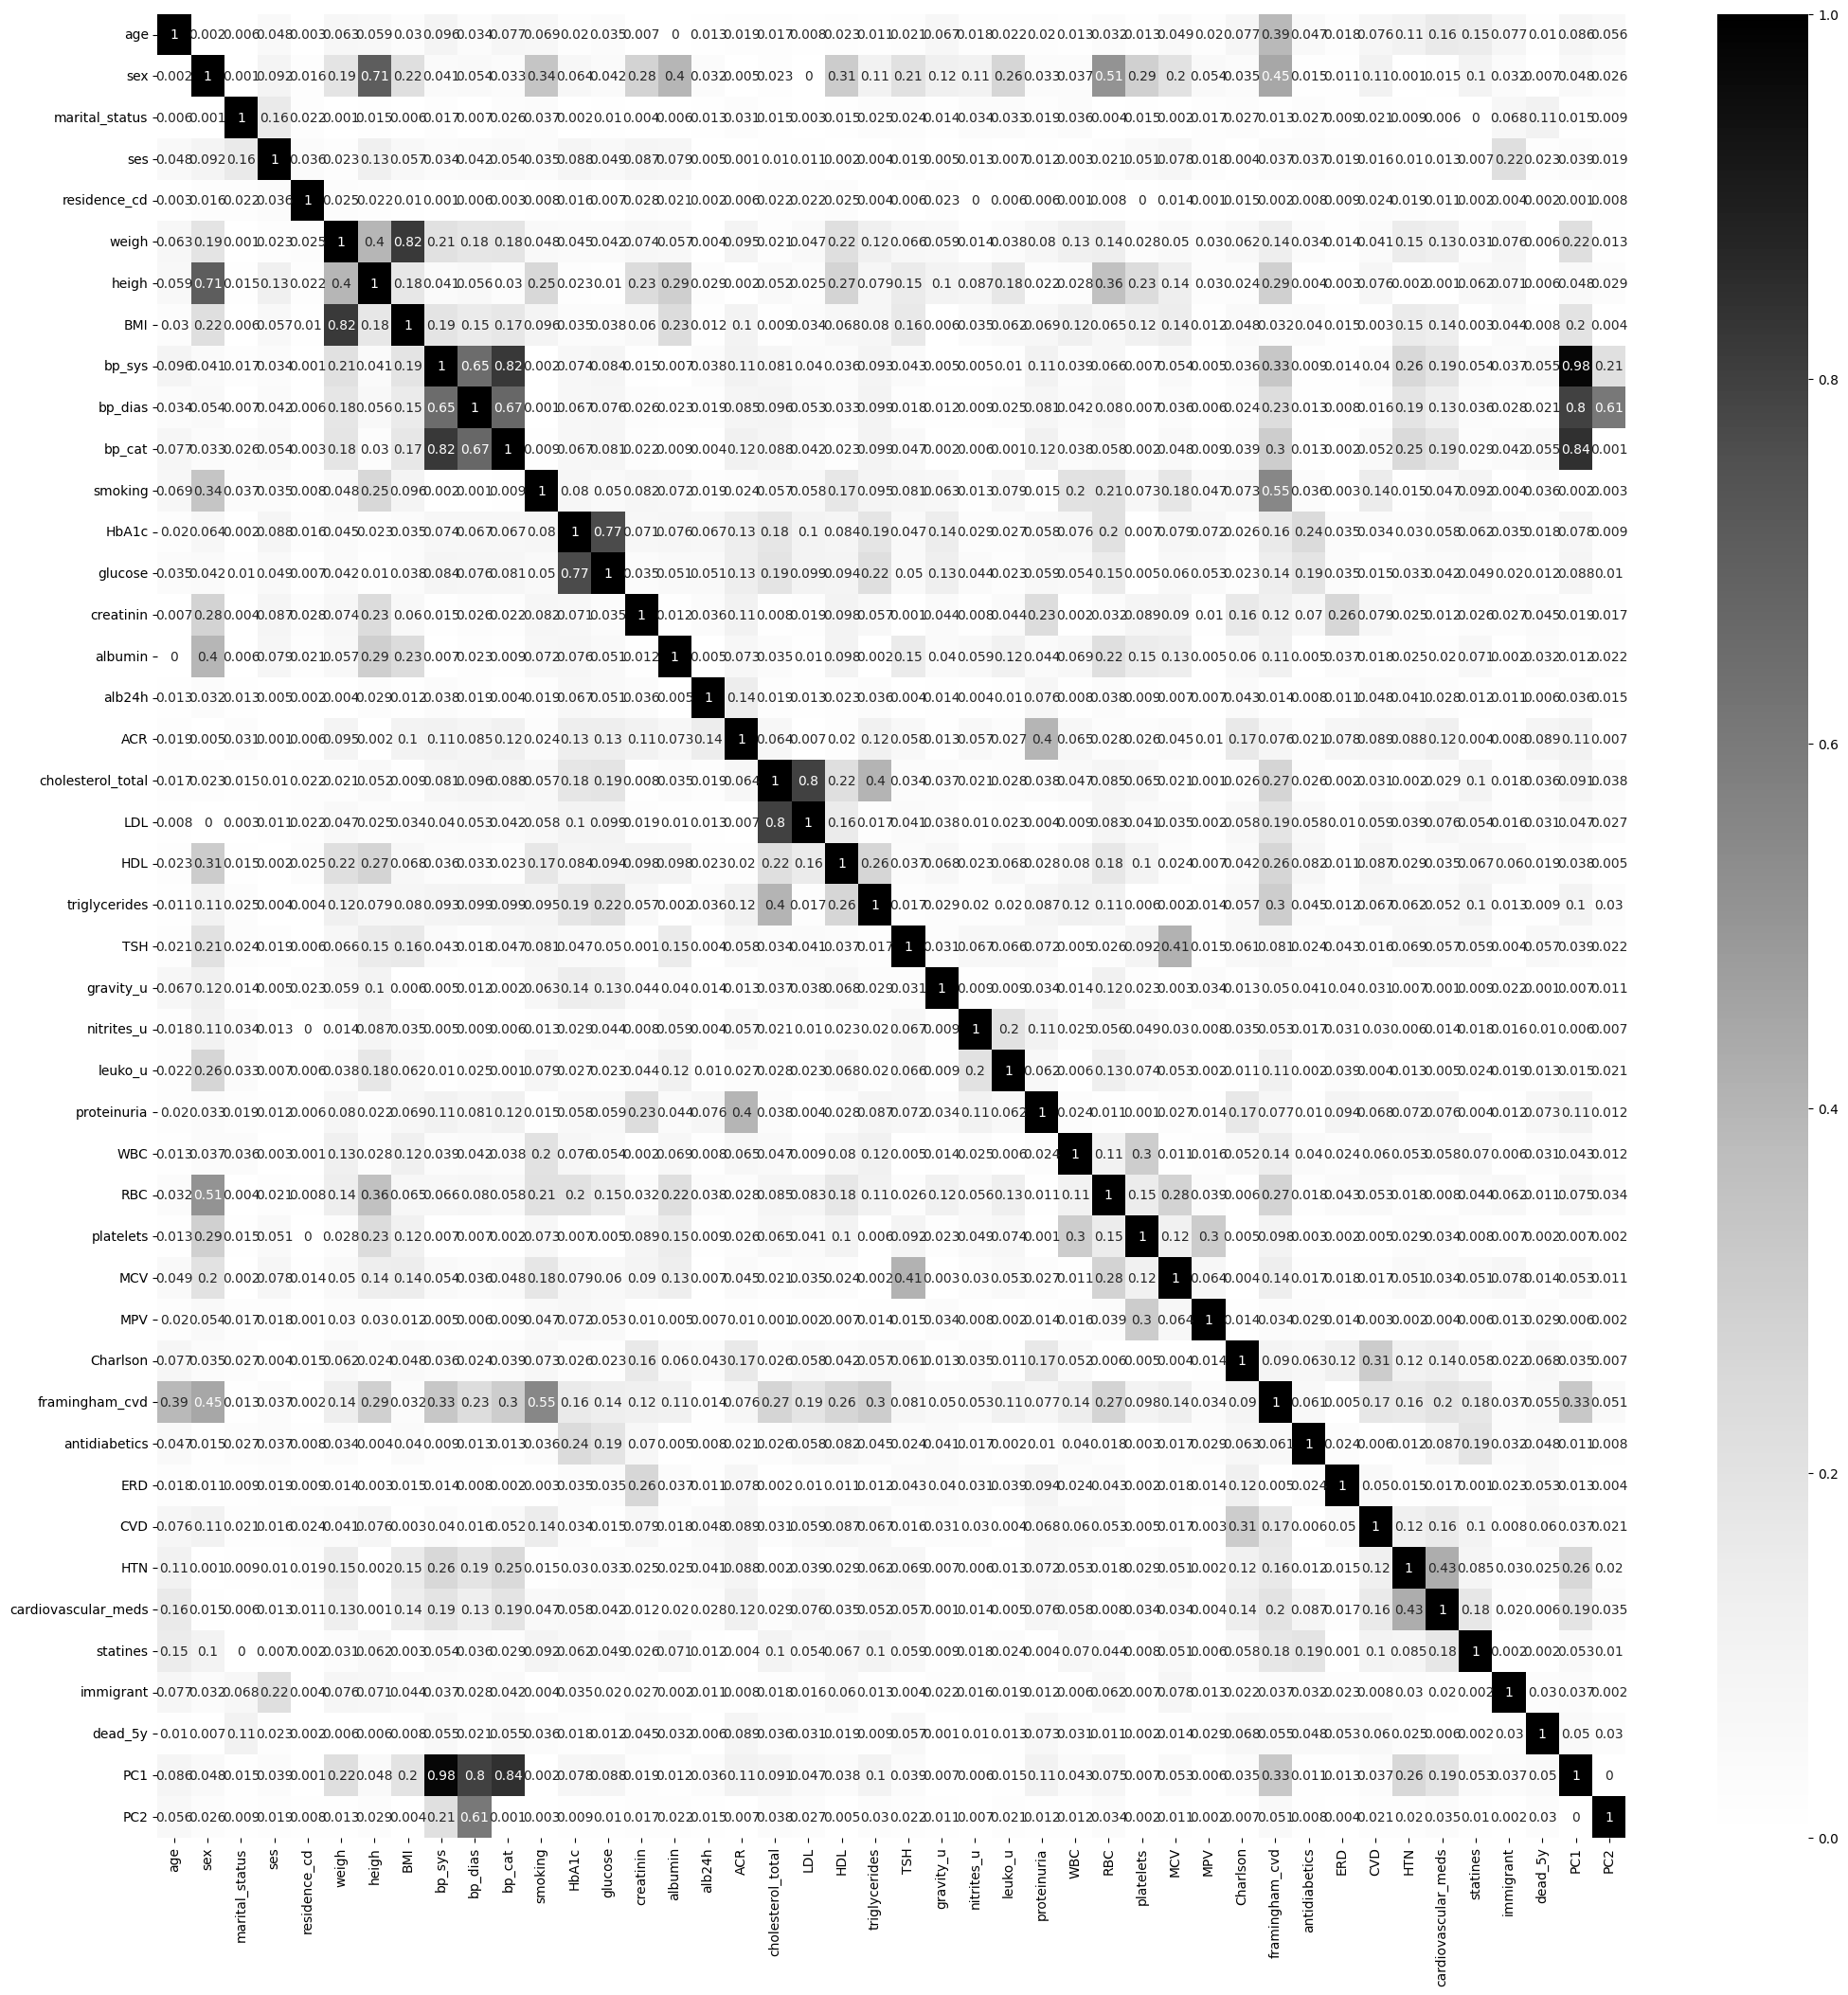

In [ ]:
plot_correlation()

המטרה בשילוב הפיצרים היא בשיפור הקורלציות והורדת המימדים כך שננסה לבטא את קאט באמצעות העמודות האחרות, אכן יש שיפור בקורלציות (להוסיף באיזה שיפור)

In [ ]:
# train_df['new_bp_model'] = (train_df['bp_sys'] * train_df['bp_dias'])
# train_df.to_csv('new_dataset.csv')
# train_df = train_df.drop(['bp_sys', 'bp_dias'], axis=1)

In [ ]:
train_df['albumin'].describe() # we know that mean is not affected by noise

count    10975.000000
mean         4.327445
std          0.329294
min          2.500000
25%          4.100000
50%          4.300000
75%          4.530000
max          5.700000
Name: albumin, dtype: float64

In [ ]:
train_df['albumin'] = train_df['albumin'].fillna(train_df['albumin'].mean()) # מלאים את החציוני באוכלוסיה כדי לשמור על העמודה ולהשתמש בה

לא סומכים על מדד הביאמי שניתן לנו, ניתן לראות שבחישוב מקומי הגדלנו את הקורלציות.

In [ ]:
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')
train_df['BMI'] = train_df['weigh'] / (train_df['heigh'] ** 2)
cor1 = train_df['BMI'].corr(train_df['weigh'])
cor2 = train_df['BMI'].corr(train_df['heigh'])
print(f'BMI <-> weigh {cor1:<.4}, BMI <-> heigh {cor2:<.4}')

BMI <-> weigh 0.817, BMI <-> heigh -0.1784
BMI <-> weigh 0.8226, BMI <-> heigh -0.1803


נזרוק את עמודות המשקל והגובה כדי להוריד מימדים ונשתמש בביאמי

In [ ]:
train_df = train_df.drop(['weigh', 'heigh'], axis=1)

In [ ]:
train_df.to_csv('new_dataset.csv')

(<AxesSubplot: xlabel='LDL', ylabel='Density'>,
 <AxesSubplot: xlabel='cholesterol_total', ylabel='Density'>)

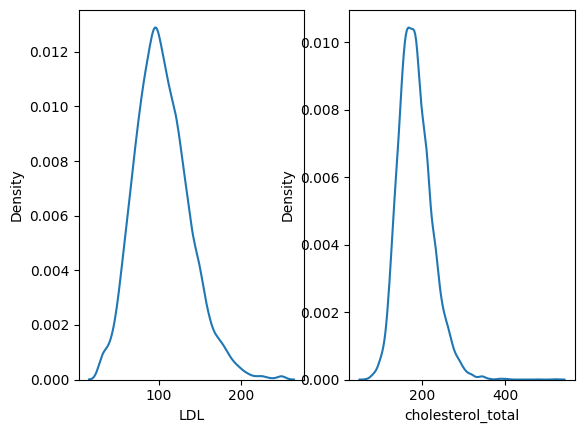

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)
sns.kdeplot(train_df['LDL'], ax=ax), sns.kdeplot(train_df['cholesterol_total'], ax=ax1)

In [ ]:
cor = train_df.corr()
cor['cholesterol_total'].loc[(np.abs(cor['cholesterol_total']) > 0.5)]

C:\Users\talro\AppData\Local\Temp\ipykernel_31992\1714489672.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train_df.corr()


cholesterol_total    1.000000
LDL                  0.795632
Name: cholesterol_total, dtype: float64

In [ ]:
# We diceded to drop the cholesterol_total feature because it's high correlation
train_df.drop(columns='cholesterol_total', axis=1)

,age,sex,marital_status,ses,residence_cd,BMI,bp_sys,bp_dias,bp_cat,smoking,...,antidiabetics,ERD,CVD,HTN,cardiovascular_meds,statines,immigrant,dead_5y,PC1,PC2
0,49,2,1,1,1,0.003281,116,66,0,1,...,1,0,0,1,1,1,0,0,-13.105286,-5.845206
1,46,2,2,1,1,0.002900,113,74,0,1,...,1,0,0,0,1,1,0,0,-11.991735,2.625743
2,46,2,1,1,1,0.002849,133,87,1,1,...,1,0,0,1,1,1,0,0,11.792809,4.692346
3,45,1,1,2,1,0.002682,100,63,0,3,...,1,0,0,0,0,1,0,0,-28.617928,-0.967872
4,49,2,1,1,1,0.002045,110,70,0,1,...,1,0,0,0,0,1,0,0,-16.515096,0.506632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12433,46,1,1,2,1,0.001913,130,80,1,1,...,1,0,0,0,1,0,0,0,5.860221,-0.074280
12434,45,2,2,1,1,0.003772,100,60,0,1,...,1,0,0,0,0,1,0,0,-30.027155,-3.615387
12435,49,1,1,1,1,0.002214,104,69,0,3,...,0,0,1,1,1,1,0,0,-22.273619,2.445946
12436,47,2,2,1,1,0.003516,96,61,0,1,...,1,0,0,0,0,1,0,0,-33.083266,-0.851670


In [ ]:
sorted_cor = cor.unstack()
sorted_cor = sorted_cor.sort_values()
sorted_cor = sorted_cor.loc[((sorted_cor > 0.5) | (sorted_cor < -0.5)) & (sorted_cor != 1)]
sorted_cor[::2]

RBC      sex                 -0.509278
smoking  framingham_cvd       0.554031
PC2      bp_dias              0.605990
bp_sys   bp_dias              0.649344
bp_dias  bp_cat               0.669956
glucose  HbA1c                0.768096
bp_dias  PC1                  0.795472
LDL      cholesterol_total    0.795632
bp_sys   bp_cat               0.822512
PC1      bp_cat               0.842507
         bp_sys               0.977386
dtype: float64

In [ ]:
# Sex and smoking are categorical feature so we'll test it again using spearman correlation
print(train_df['HbA1c'].describe(), train_df['glucose'].describe())

count    12438.000000
mean         7.623666
std          1.867250
min          4.000000
25%          6.300000
50%          7.100000
75%          8.500000
max         16.800000
Name: HbA1c, dtype: float64 count    12438.000000
mean       153.757276
std         64.724782
min         40.000000
25%        110.000000
50%        134.000000
75%        177.000000
max        883.000000
Name: glucose, dtype: float64


C:\Users\talro\AppData\Local\Temp\ipykernel_31992\1575577011.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train_df.corr(method=method)


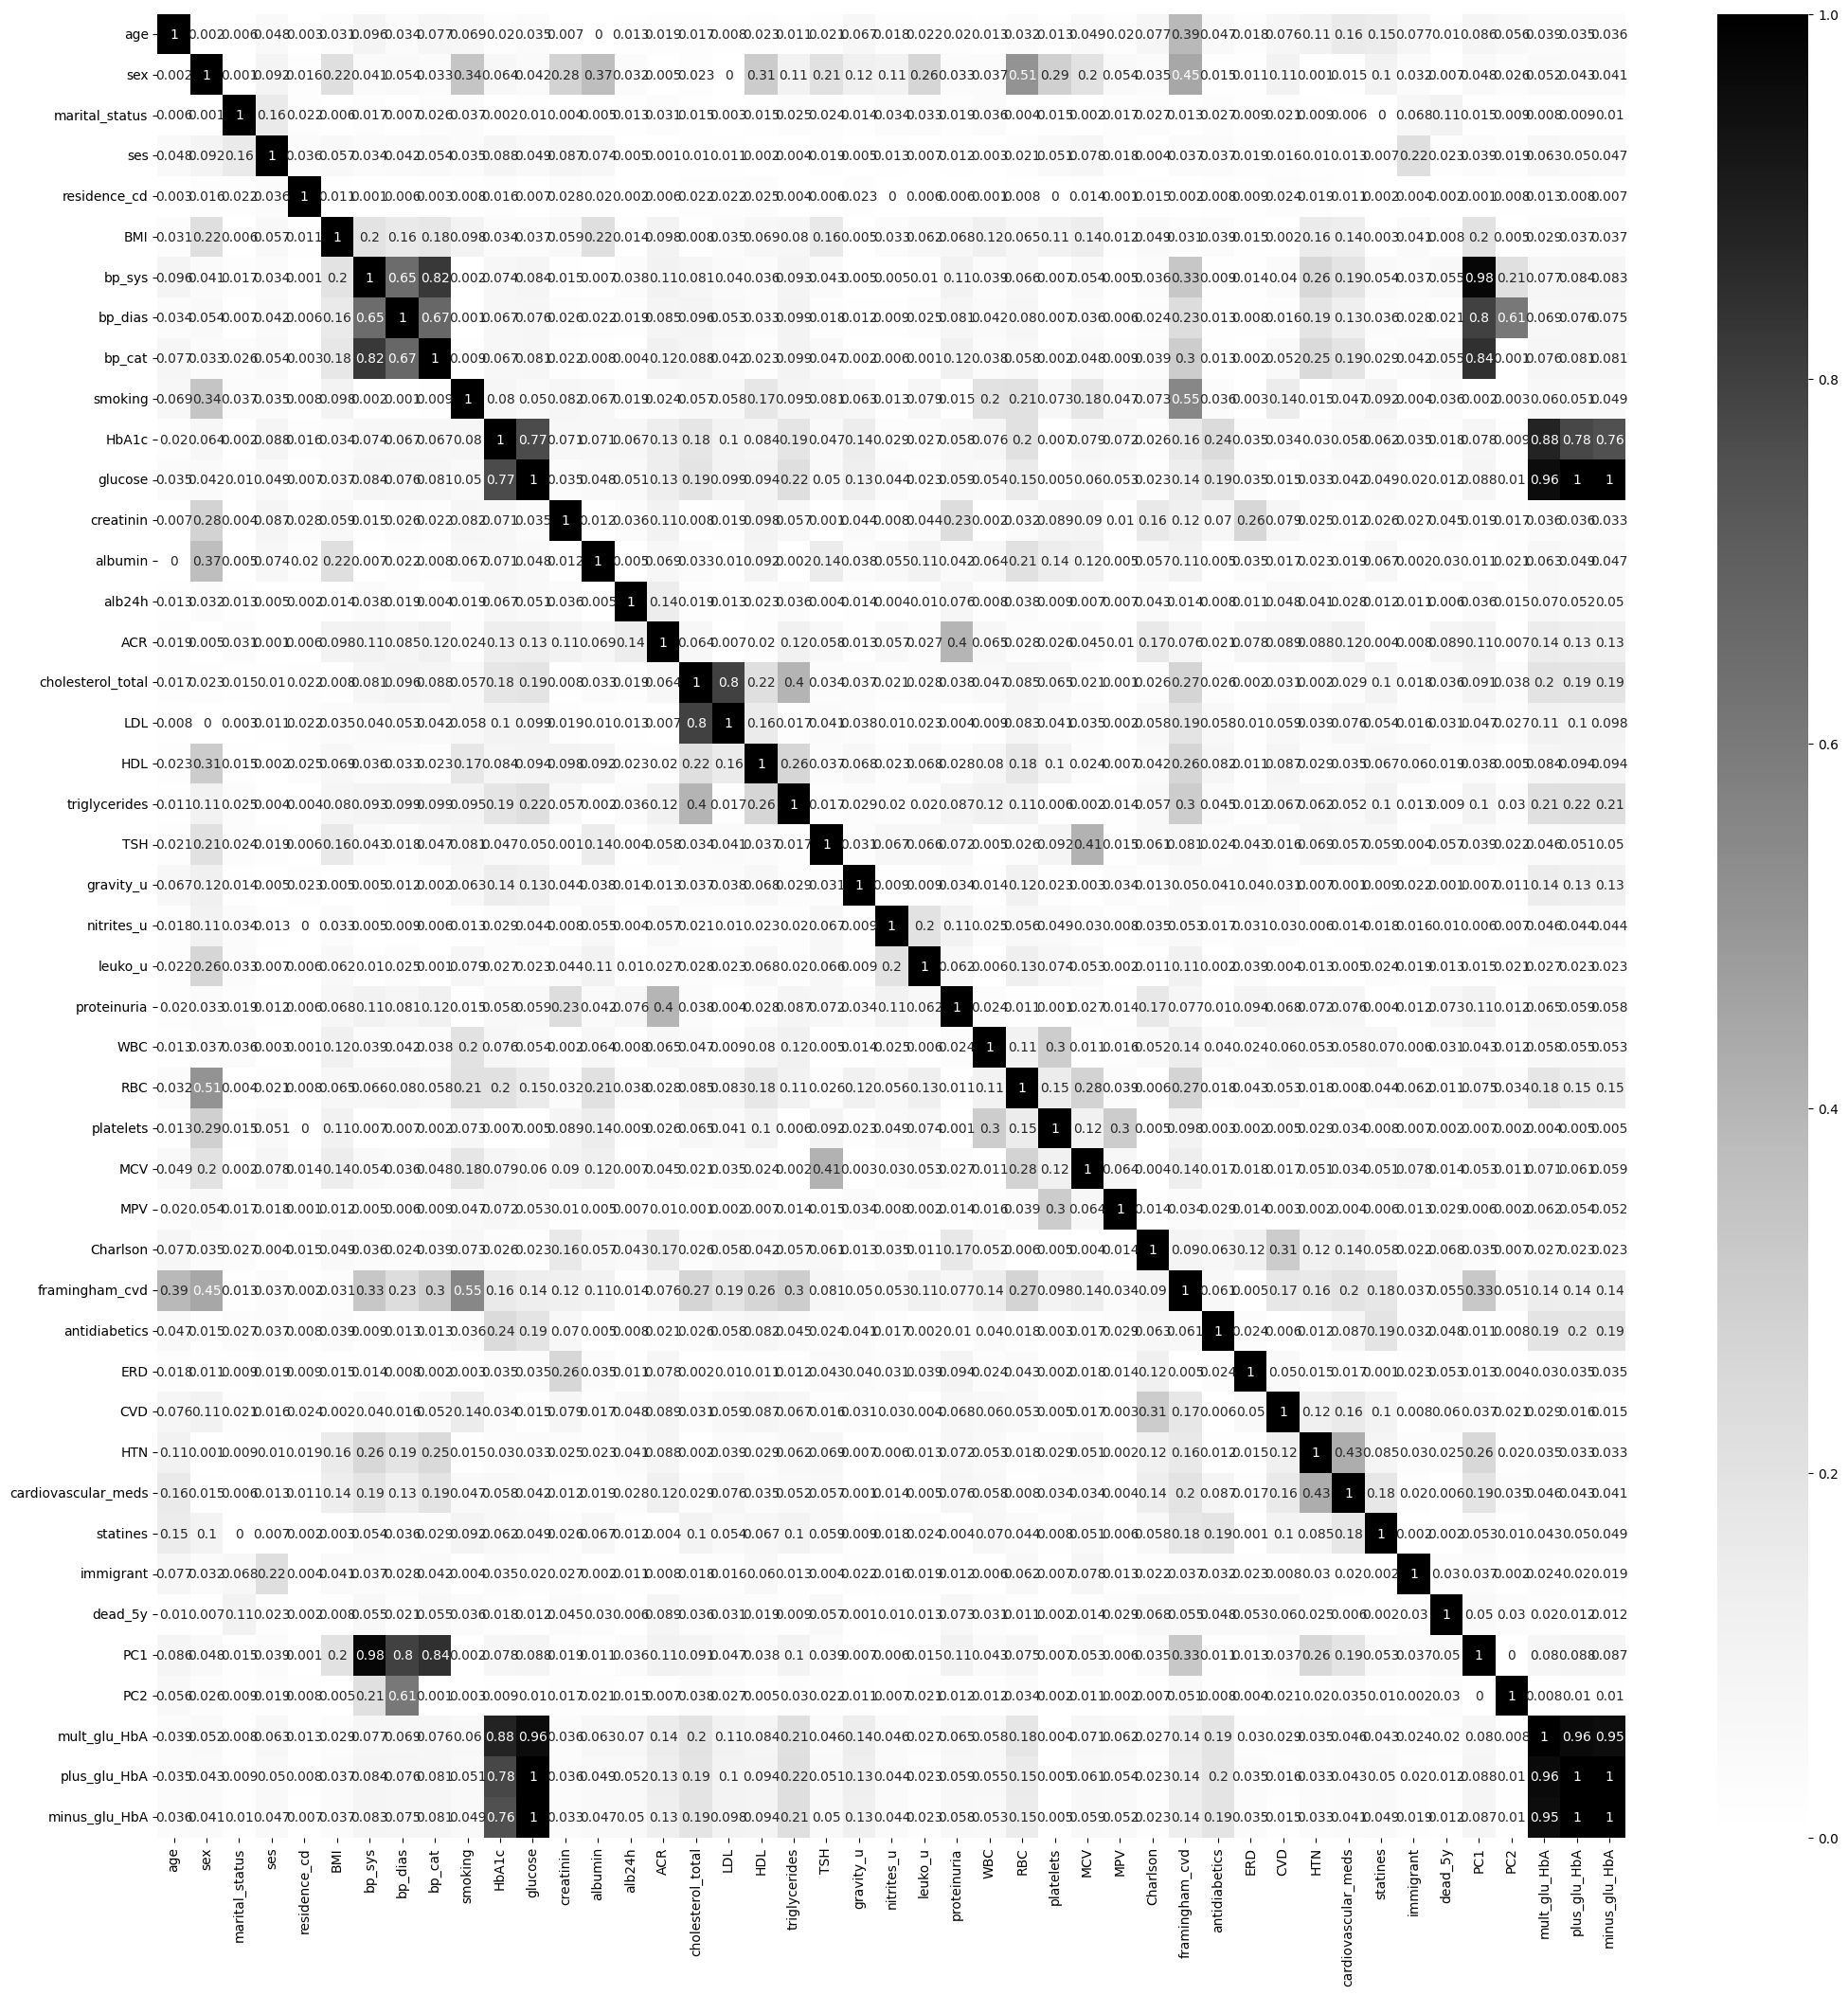

In [ ]:
train_df['mult_glu_HbA'] = train_df['HbA1c'] * train_df['glucose']
plot_correlation()